Necessary Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import numpy as np


Getting data from data/sentiment_train.csv

In [7]:
data = pd.read_csv('https://github.com/dushyant-007/transfer-learning-for-sentiment-classification-BERT/raw/main/data/sentiment_train.csv')
print('info of the data \n')
print(data.info())
print('first few rows of the data: \n',data.head())

info of the data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5668 non-null   object
 1   label     5668 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 88.7+ KB
None
first few rows of the data: 
                                             sentence  label
0    Ok brokeback mountain is such a horrible movie.      0
1                 Brokeback Mountain was so awesome.      1
2  friday hung out with kelsie and we went and sa...      0
3  I am going to start reading the Harry Potter s...      1
4       Is it just me, or does Harry Potter suck?...      0


Above is how the data looks

Now let us work on it a little bit

1. Make train - test splits.

In [8]:
from sklearn.model_selection import train_test_split

x_tr , x_te , y_tr, y_te = train_test_split(data['sentence'].values,
                                            data['label'].values,
                                            train_size=0.8,
                                            random_state=1)

x_tr, x_va, y_tr, y_va = train_test_split(x_tr,
                                          y_tr,
                                          train_size=0.8,
                                          random_state=1)

print(f'shape of x_train is {x_tr.shape}')
print(f'shape of x_test is {x_te.shape}')
print(f'shape of x_val is {x_va.shape}')
print(f'shape of y_train is {y_tr.shape}')
print(f'shape of y_test is {y_te.shape}')
print(f'shape of y_validation is {y_va.shape}')

shape of x_train is (3627,)
shape of x_test is (1134,)
shape of x_val is (907,)
shape of y_train is (3627,)
shape of y_test is (1134,)
shape of y_validation is (907,)


In [9]:
from transformers import AutoModel
bert = AutoModel.from_pretrained('bert-base-uncased')
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's see , what should be the padding length. I want to take the median

(array([1340.,  700.,  583.,  443.,  188.,  168.,   99.,   22.,   80.,
           4.]),
 array([ 3. ,  6.7, 10.4, 14.1, 17.8, 21.5, 25.2, 28.9, 32.6, 36.3, 40. ]),
 <BarContainer object of 10 artists>)

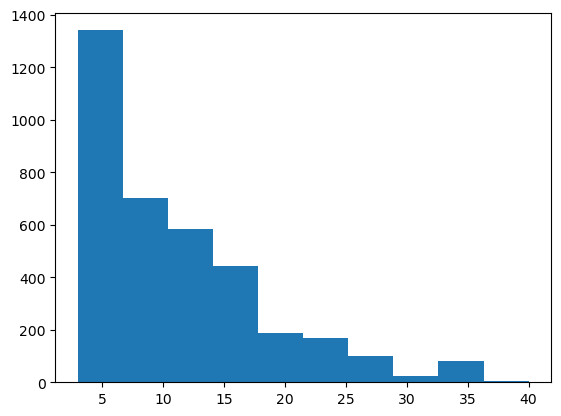

In [10]:
len_of_sentences_in_train_data = [len(i.split()) for i in x_tr]
plt.hist(len_of_sentences_in_train_data)

From looking at the histogram , I think we should take 15 to be the padding.

Alright, Now let's tokenize the data.

In [11]:
pad_len = 15

x_tr_token = tokenizer.batch_encode_plus(
    x_tr.tolist(),
    max_length= pad_len,
    pad_to_max_length = True,
    truncation=True
)

x_va_token = tokenizer.batch_encode_plus(
    x_va.tolist(),
    max_length=pad_len,
    pad_to_max_length = True,
    truncation= True
)

x_te_token = tokenizer.batch_encode_plus(
    x_te.tolist(),
    max_length=pad_len,
    pad_to_max_length = True,
    truncation=True
)

# getting the sequence data
x_tr_seq = torch.tensor(x_tr_token['input_ids'])
x_va_seq = torch.tensor(x_va_token['input_ids'])
x_te_seq = torch.tensor(x_te_token['input_ids'])

# getting the attention mask
x_tr_mask = torch.tensor(x_tr_token['attention_mask'])
x_te_mask = torch.tensor(x_te_token['attention_mask'])
x_va_mask = torch.tensor(x_va_token['attention_mask'])

# getting the labels
y_tr = torch.tensor(y_tr.tolist())
y_va = torch.tensor(y_va.tolist())
y_te = torch.tensor(y_te.tolist())



C:\Users\Dushyant S. Udawat\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
print(x_tr_seq)
print(f'the shape of the x_tr_seq is {x_tr_seq.shape}')

tensor([[  101,  1045,  2066,  ...,  1055,  2006,   102],
        [  101,  1045,  2293,  ...,     0,     0,     0],
        [  101,  1045,  5223,  ...,  3791,  1037,   102],
        ...,
        [  101,  4302, 10693,  ...,  2758, 11543,   102],
        [  101,  2029,  2003,  ...,  2480,  1045,   102],
        [  101,  4830, 23765,  ...,     0,     0,     0]])
the shape of the x_tr_seq is torch.Size([3627, 15])


In [14]:
print(x_tr[:3])

print(x_tr_seq[:3])

["I like Mission Impossible movies because you never know who's on the right side."
 'I love Harry Potter..'
 'I hate Harry Potter, that daniel wotshisface needs a fucking slap...']
tensor([[  101,  1045,  2066,  3260,  5263,  5691,  2138,  2017,  2196,  2113,
          2040,  1005,  1055,  2006,   102],
        [  101,  1045,  2293,  4302, 10693,  1012,  1012,   102,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  5223,  4302, 10693,  1010,  2008,  3817, 24185,  3215,
         24158, 12172,  3791,  1037,   102]])


So, as can be seen the tokenizer just makes the sentence into dictionary indexes. It is nothing special , there is no machine learning here. However, we should remember that the dictionary indexes here are related to their corresponding embeddings in the trained bert model.

# Defining the model

In [15]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_arch(nn.Module):
    def __init__(self, bert):
        super(BERT_arch, self).__init__()
        self.bert = bert

        # adding a dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2
        self. fc2 = nn.Linear(512, 2)

        # softmax activation
        self.softmax = nn.LogSoftmax(dim =1 )

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.softmax(x)

        return x




In [16]:
from torchsummary import summary



In [23]:
model = BERT_arch(bert)
optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-5)  # learning rate
print(summary(model=model, input_data=(x_tr_seq[:32, :], x_tr_mask[:32, :])))

Layer (type:depth-idx)                   Output Shape              Param #
├─BertModel: 1-1                         [-1, 15, 768]             --
|    └─BertEmbeddings: 2-1               [-1, 15, 768]             --
|    |    └─Embedding: 3-1               [-1, 15, 768]             (23,440,896)
|    |    └─Embedding: 3-2               [-1, 15, 768]             (1,536)
|    |    └─Embedding: 3-3               [-1, 15, 768]             (393,216)
|    |    └─LayerNorm: 3-4               [-1, 15, 768]             (1,536)
|    |    └─Dropout: 3-5                 [-1, 15, 768]             --
|    └─BertEncoder: 2-2                  [-1, 15, 768]             --
|    └─BertPooler: 2-3                   [-1, 768]                 --
|    |    └─Linear: 3-6                  [-1, 768]                 (590,592)
|    |    └─Tanh: 3-7                    [-1, 768]                 --
├─Linear: 1-2                            [-1, 512]                 393,728
├─ReLU: 1-3                              [-1, 

In [70]:
# making the data_loaders here
from torch.utils.data import DataLoader, TensorDataset
batch_size = 256
training_data = TensorDataset(x_tr_seq, x_tr_mask, y_tr)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
testing_data = TensorDataset(x_te_seq, x_te_mask, y_te)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)
validation_data = TensorDataset(x_va_seq, x_va_mask, y_va)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [71]:
def train(model, train_dataloader, device, loss_fn, optimizer):
    model.train()
    model.to(device)

    losses , accuracy = [], []


    for step , batch in enumerate(train_dataloader):

        
        # pushing to device
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id , mask)

        # compute the loss between actual and predicted values
        loss = loss_fn(preds, labels)

        # backward the loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update the gradients of the model
        optimizer.step()

        # printout the results.
        losses.append(loss.detach().item())
        preds = preds.cpu()
        labels = labels.cpu()
        accuracy.append(sum(preds.detach().argmax(dim=1) == labels))
        #print(f'step - {step}, the loss is {losses[-1]}, accuracy is {accuracy[-1]}')


    return losses, accuracy

In [72]:
# implementing the evaluate function here.

def evaluate(model, val_dataloader, loss_fn, device):

    print('\nEvaluating ... ')

    model.eval()

    losses, accuracy = [], []

    total_preds = []

    for step, batch in enumerate(val_dataloader):

        # extract the data from the batch
        batch = [r.to(device) for r in batch]
        input_ids, mask, labels = batch


        # pass through the model to produce outputs
        pred = model(input_ids, mask)

        # calculate the loss
        loss = loss_fn(pred, labels)

        #
        losses.append(loss.detach().item())
        pred = pred.cpu()
        labels = labels.cpu()
        accuracy.append(sum(pred.cpu().detach().argmax(dim=1) == labels))
        #print(f'step - {step}, the loss is {losses[-1]}, accuracy is {accuracy[-1]}')

    return losses, accuracy

In [73]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
no_epochs = 150
if not train_loss:
  train_loss, val_loss = [], []
  train_acc, val_acc = [], []
for epoch in range(no_epochs):
  losses , accuracy = train(model, train_dataloader, device, nn.CrossEntropyLoss(), optimizer)
  train_loss.append(sum(losses)/len(losses))
  train_acc.append(sum(accuracy)/len(accuracy)/batch_size)
  print(f'epoch : {epoch}, loss : {train_loss[-1]}, accuracy : {train_acc[-1]}')
  losses_ev, accuracy_ev = evaluate(model, val_dataloader, nn.CrossEntropyLoss(), device)
  val_loss.append(sum(losses_ev)/len(losses_ev))
  val_acc.append(sum(accuracy_ev)/len(accuracy_ev)/batch_size)
  print(f'\t\tepoch : evaluation, loss : {val_loss[-1]}, accuracy : {val_acc[-1]}')


epoch : 0, loss : 0.23587706486384075, accuracy : 0.8804687261581421

Evaluating ... 
		epoch : evaluation, loss : 0.18115905299782753, accuracy : 0.8505859375
epoch : 1, loss : 0.240778844555219, accuracy : 0.8776041865348816

Evaluating ... 
		epoch : evaluation, loss : 0.1807681769132614, accuracy : 0.849609375
epoch : 2, loss : 0.23624376356601715, accuracy : 0.8765624761581421

Evaluating ... 
		epoch : evaluation, loss : 0.18027178570628166, accuracy : 0.8505859375
epoch : 3, loss : 0.2355123281478882, accuracy : 0.8770833611488342

Evaluating ... 
		epoch : evaluation, loss : 0.18074443191289902, accuracy : 0.849609375
epoch : 4, loss : 0.23615099589029948, accuracy : 0.875

Evaluating ... 
		epoch : evaluation, loss : 0.17985369637608528, accuracy : 0.8505859375
epoch : 5, loss : 0.23781247834364574, accuracy : 0.8768228888511658

Evaluating ... 
		epoch : evaluation, loss : 0.18035541847348213, accuracy : 0.8505859375
epoch : 6, loss : 0.23508488138516745, accuracy : 0.8773437

167


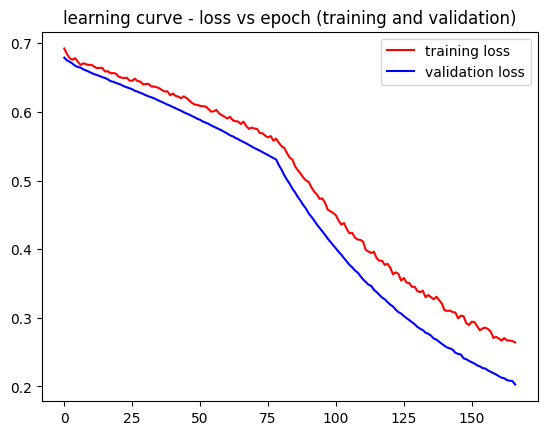

In [53]:
# lets draw a graph showing epochs 
print(len(train_acc))
no_epochs = len(train_acc)
import matplotlib.pyplot as plt
plt.figure()
plt.title('learning curve - loss vs epoch (training and validation)')
plt.plot(list(range(no_epochs)) , train_loss, 'r', label = 'training loss')
plt.plot(list(range(no_epochs)) , val_loss, 'b', label = 'validation loss')
plt.legend()
plt.show()

167


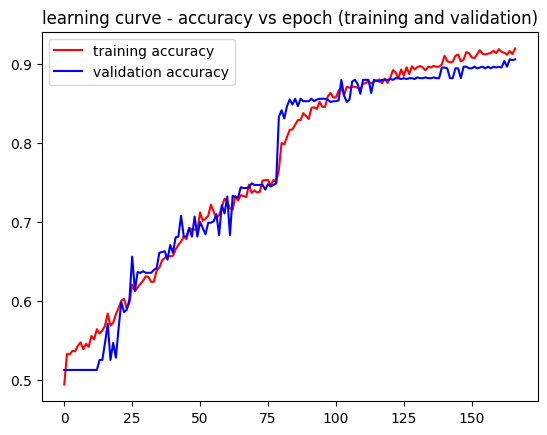

In [63]:
print(len(train_acc))
no_epochs = len(train_acc)
import matplotlib.pyplot as plt
plt.figure()
plt.title('learning curve - accuracy vs epoch (training and validation)')
plt.plot(list(range(no_epochs)) , train_acc, 'r', label = 'training accuracy')
plt.plot(list(range(no_epochs)) , val_acc, 'b', label = 'validation accuracy')
plt.legend()
plt.show()

In [74]:
# now let's test on new data

with torch.no_grad():
    preds = model(x_te_seq.to(device), x_te_mask.to(device))
    preds = preds.detach().cpu().numpy()

from sklearn.metrics import classification_report
pred = np.argmax(preds, axis =1)
print(classification_report(y_te, pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       508
           1       0.95      0.99      0.97       626

    accuracy                           0.97      1134
   macro avg       0.97      0.96      0.97      1134
weighted avg       0.97      0.97      0.97      1134

